In [1]:
import numpy as np
from numpy import linalg as LA
import struct
from array import array
import random

In [2]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

def show_images(images, title_texts):
    imagesss = []
    for i in range(len(images)):
        # img = np.concatenate(images[i])
        img = images[i].reshape(28, 28)
        imagesss.append(img)
    cols = 5
    rows = int(len(imagesss)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(imagesss, title_texts):        
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);   
        index += 1

In [3]:
train_images_fp = '/Users/shivi/Documents/sem4/sml/ass2/archive-2/train-images.idx3-ubyte'
train_labels_fp = '/Users/shivi/Documents/sem4/sml/ass2/archive-2/train-labels.idx1-ubyte'
test_images_fp = '/Users/shivi/Documents/sem4/sml/ass2/archive-2/t10k-images.idx3-ubyte'
test_labels_fp = '/Users/shivi/Documents/sem4/sml/ass2/archive-2/t10k-labels.idx1-ubyte'

In [4]:
def read(img_fp, label_fp, n=None):
    labels = []
    with open(label_fp, 'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        labels = array("B", f.read())
    with open(img_fp, 'rb') as f:
        magic, size, rows, cols = struct.unpack(">IIII", f.read(16))
        image_data = array("B", f.read())
        images = []
        for i in range(size):
            img = np.array(image_data[i*rows*cols : (i+1)*rows*cols])
            img = img.reshape(1,784)
            img = img/255 #normalizing
            images.append(img)
    if n==None: n = size
    zimg = np.zeros((n,784))
    oimg = np.zeros((n,784))
    cnt = 0
    while(cnt!=n):
        r = random.randint(1, size-1)
        if(labels[r]==0):
            zimg[cnt] = images[r]
            cnt+=1
    zimg = zimg
    cnt = 0
    while(cnt!=n):
        r = random.randint(1, size-1)
        if(labels[r]==1):
            oimg[cnt] = images[r]
            cnt+=1
    oimg = oimg
    images = np.vstack((zimg, oimg))

    return (images, np.array([0]*n + [1]*n))

x_train, y_train = read(train_images_fp, train_labels_fp,1000)
x_test, y_test = read(test_images_fp, test_labels_fp)
#(n_samples, n_dim)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(2000, 784) (2000,)
(20000, 784) (20000,)


In [5]:
def pca(X, variance_retained=0.95, p=None):
    mu = X.mean(axis=1, keepdims=True)
    X_centered = X - mu
    cov = np.cov(X_centered, rowvar=True)
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    eigenvalues = eigenvalues.real
    eigenvectors = eigenvectors.real
    sorted_idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_idx]
    eigenvectors = eigenvectors[:, sorted_idx]
    
    total_variance = np.sum(eigenvalues)
    cumulative_variance = np.cumsum(eigenvalues) / total_variance
    px = np.argmax(cumulative_variance >= variance_retained) + 1
    if p==None: p=px
    return eigenvectors[:, :p], mu

Up, pca_mean = pca(x_train.T, p=5)
x_train_pca = (Up.T @ (x_train.T - pca_mean)).T
x_test_pca = (Up.T @ (x_test.T - pca_mean)).T

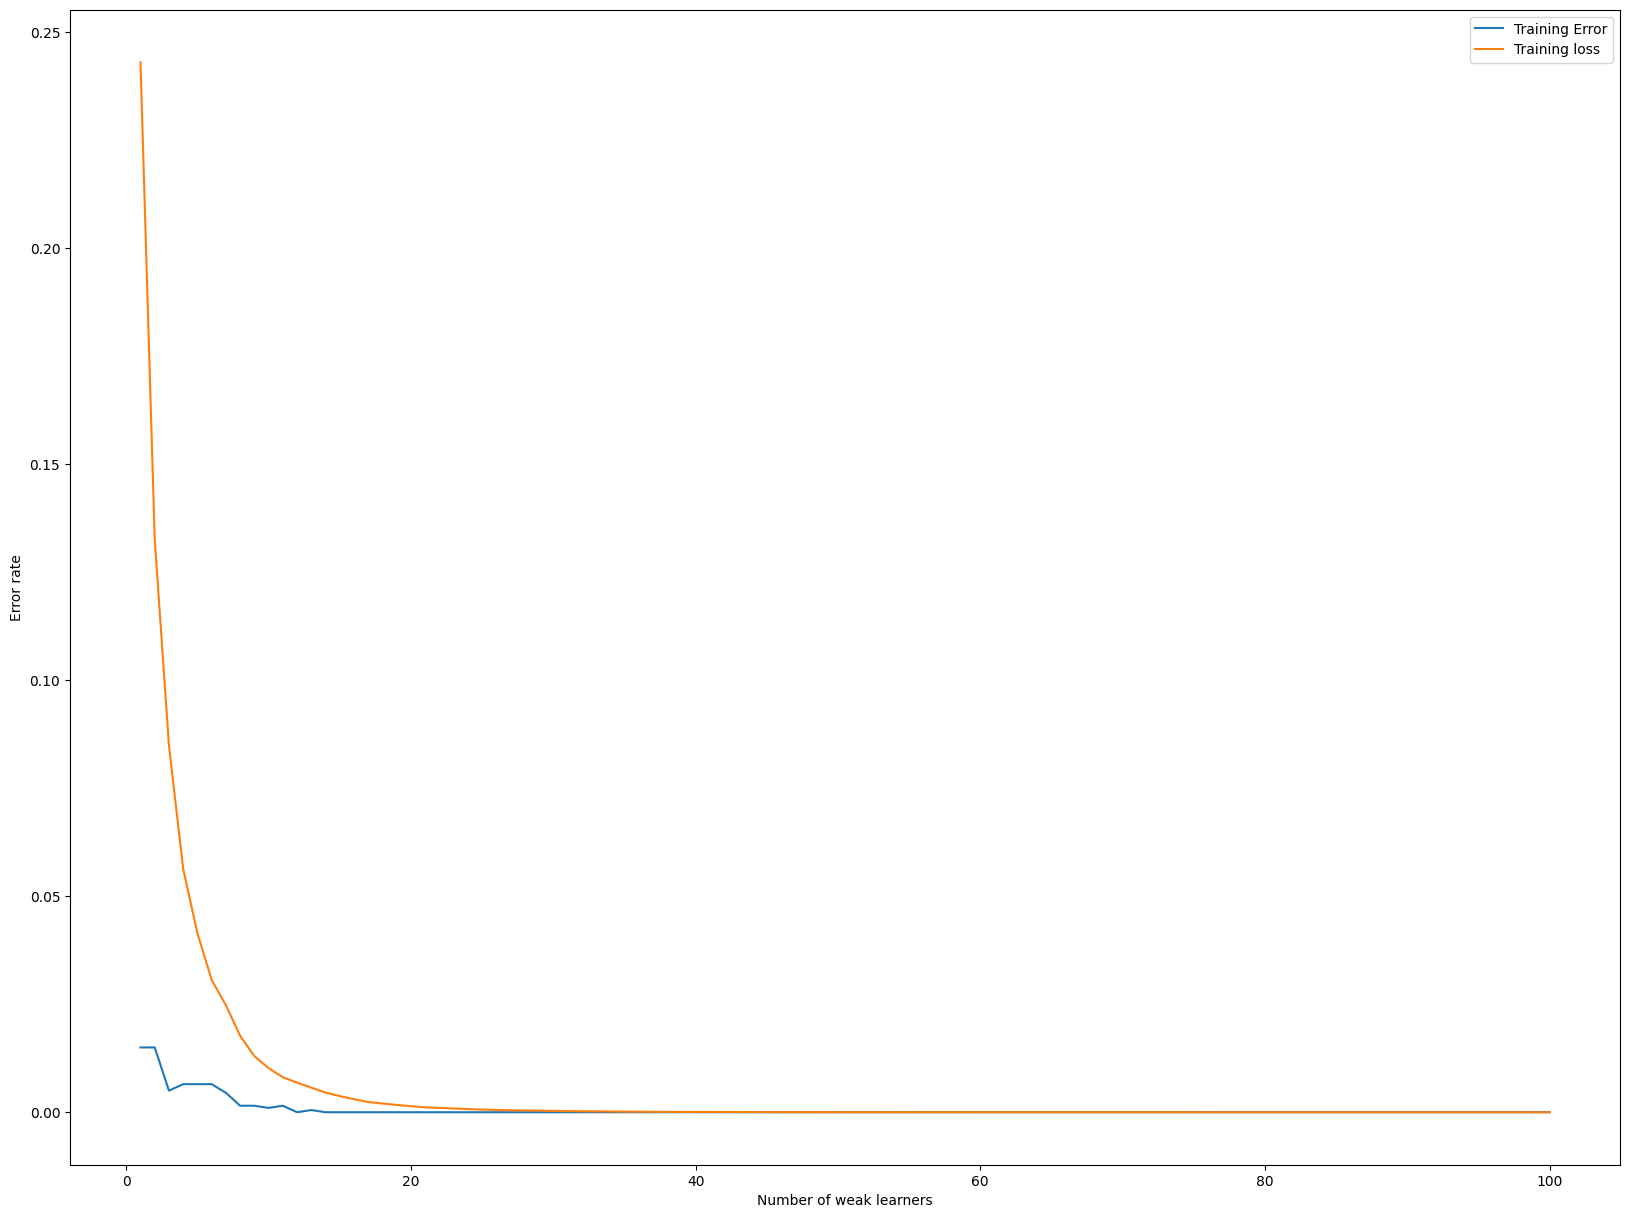

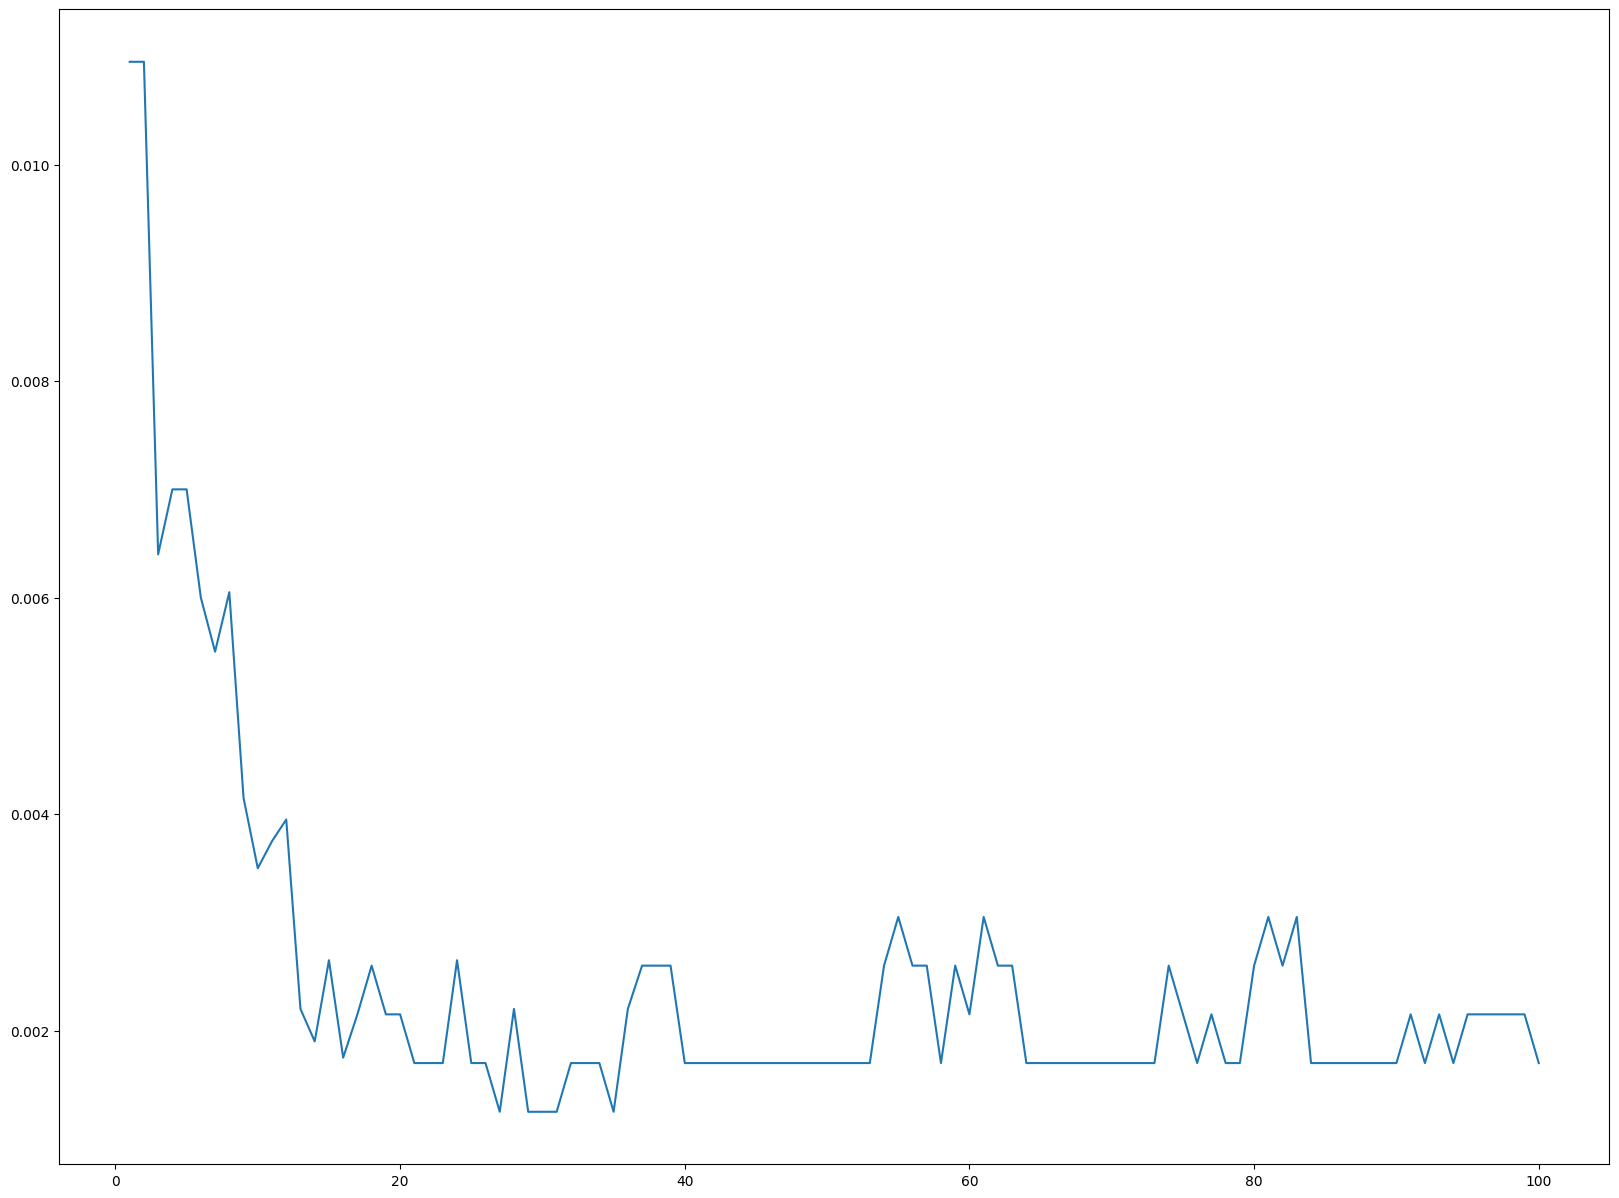

In [6]:
'''
need to do adaboost with weak classifier as decision stump
=> need to find best decision stump at each step

'''

class Adaboost():
    def __init__(self, x, y, n):
        self.x = x
        self.y = np.array(y * 2 - 1.0)  # convert {0,1} to {-1,1}
        self.n = n
        self.weaks = []  # each stump can be specified by a (value, dimension, polarity) tuple
        self.alphas = []  # weight of each weak classifier

        # for plots
        self.trainx = self.testx = np.arange(1, self.n + 1)
        self.trainy = []
        self.testy = []
        self.trainlossx = np.arange(1,self.n+1)
        self.trainlossy = []

    def stump_pred(self, x, stump):  # modified to accept any input x
        val, dim, p = stump[0], stump[1], stump[2]
        vals = x[:, dim]
        preds = np.ones(x.shape[0])
        if p == 1:
            preds[vals < val] = -1
        else:
            preds[vals > val] = -1
        return preds

    def weighted_loss(self, preds, w):
        return sum(w[preds != self.y]) / sum(w)

    def fit(self):
        n_samples = self.x.shape[0]
        n_dims = self.x.shape[1]
        w = np.full(n_samples, 1 / n_samples)
        
        for i in range(self.n):
            min_l = float('inf')
            best_stump = None
            
            # find best stump
            for dim in range(n_dims):
                vals = np.unique(self.x[:, dim])
                splits = np.linspace(np.min(vals), np.max(vals), 5)[1:-1]
                for split in splits:
                    for polarity in [1, -1]:
                        preds = self.stump_pred(self.x, (split, dim, polarity))
                        l = self.weighted_loss(preds, w)
                        if l < min_l:
                            min_l = l
                            best_stump = (split, dim, polarity)
            
            if best_stump is None:
                break  # no good stump found
            
            preds = self.stump_pred(self.x, best_stump)
            err = self.weighted_loss(preds, w)
            alpha = 0.5 * np.log((1 - err) / max(err, 1e-10))
            
            # Update weights
            w = w * np.exp(-alpha * self.y * preds)
            w = w / np.sum(w)  # renormalize
            
            self.weaks.append(best_stump)
            self.alphas.append(alpha)
            
            # Track training error
            final_pred = self._predict(self.x, len(self.weaks))
            train_err = np.sum(final_pred != self.y) / n_samples
            self.trainy.append(train_err)
            # self.trainlossy.append(err)

            F = np.zeros(n_samples)
            for h, a in zip(self.weaks, self.alphas):
                F += a * self.stump_pred(self.x, h)
            exp_loss = np.mean(np.exp(-self.y * F))
            self.trainlossy.append(exp_loss)
    
    def _predict(self, x, n):  # predict using first n weak classifiers
        pred = np.zeros(x.shape[0])
        for h, a in zip(self.weaks[:n], self.alphas[:n]):
            pred += a * self.stump_pred(x, h)
        return np.sign(pred)

    def predict(self, x_test, y_test):
        y_test = y_test * 2 - 1  # convert {0,1} to {-1,1}
        self.testy = []
        for i in range(1, self.n + 1):
            preds = self._predict(x_test, i)
            test_err = np.sum(preds != y_test) / len(y_test)
            self.testy.append(test_err)
        return self._predict(x_test, self.n)

    def plot(self):
        plt.figure(figsize=(20, 15))
        plt.plot(self.trainx[:len(self.trainy)], self.trainy, label='Training Error')
        plt.plot(self.trainlossx[:len(self.trainy)], self.trainlossy, label='Training loss')
        plt.xlabel('Number of weak learners')
        plt.ylabel('Error rate')
        plt.legend()
        plt.figure(figsize=(20, 15))
        if len(self.testy) > 0:
            plt.plot(self.testx[:len(self.testy)], self.testy, label='Test Error')
        plt.show()

model = Adaboost(x_train, y_train, 100)   
model.fit()
model.predict(x_test, y_test)
model.plot()

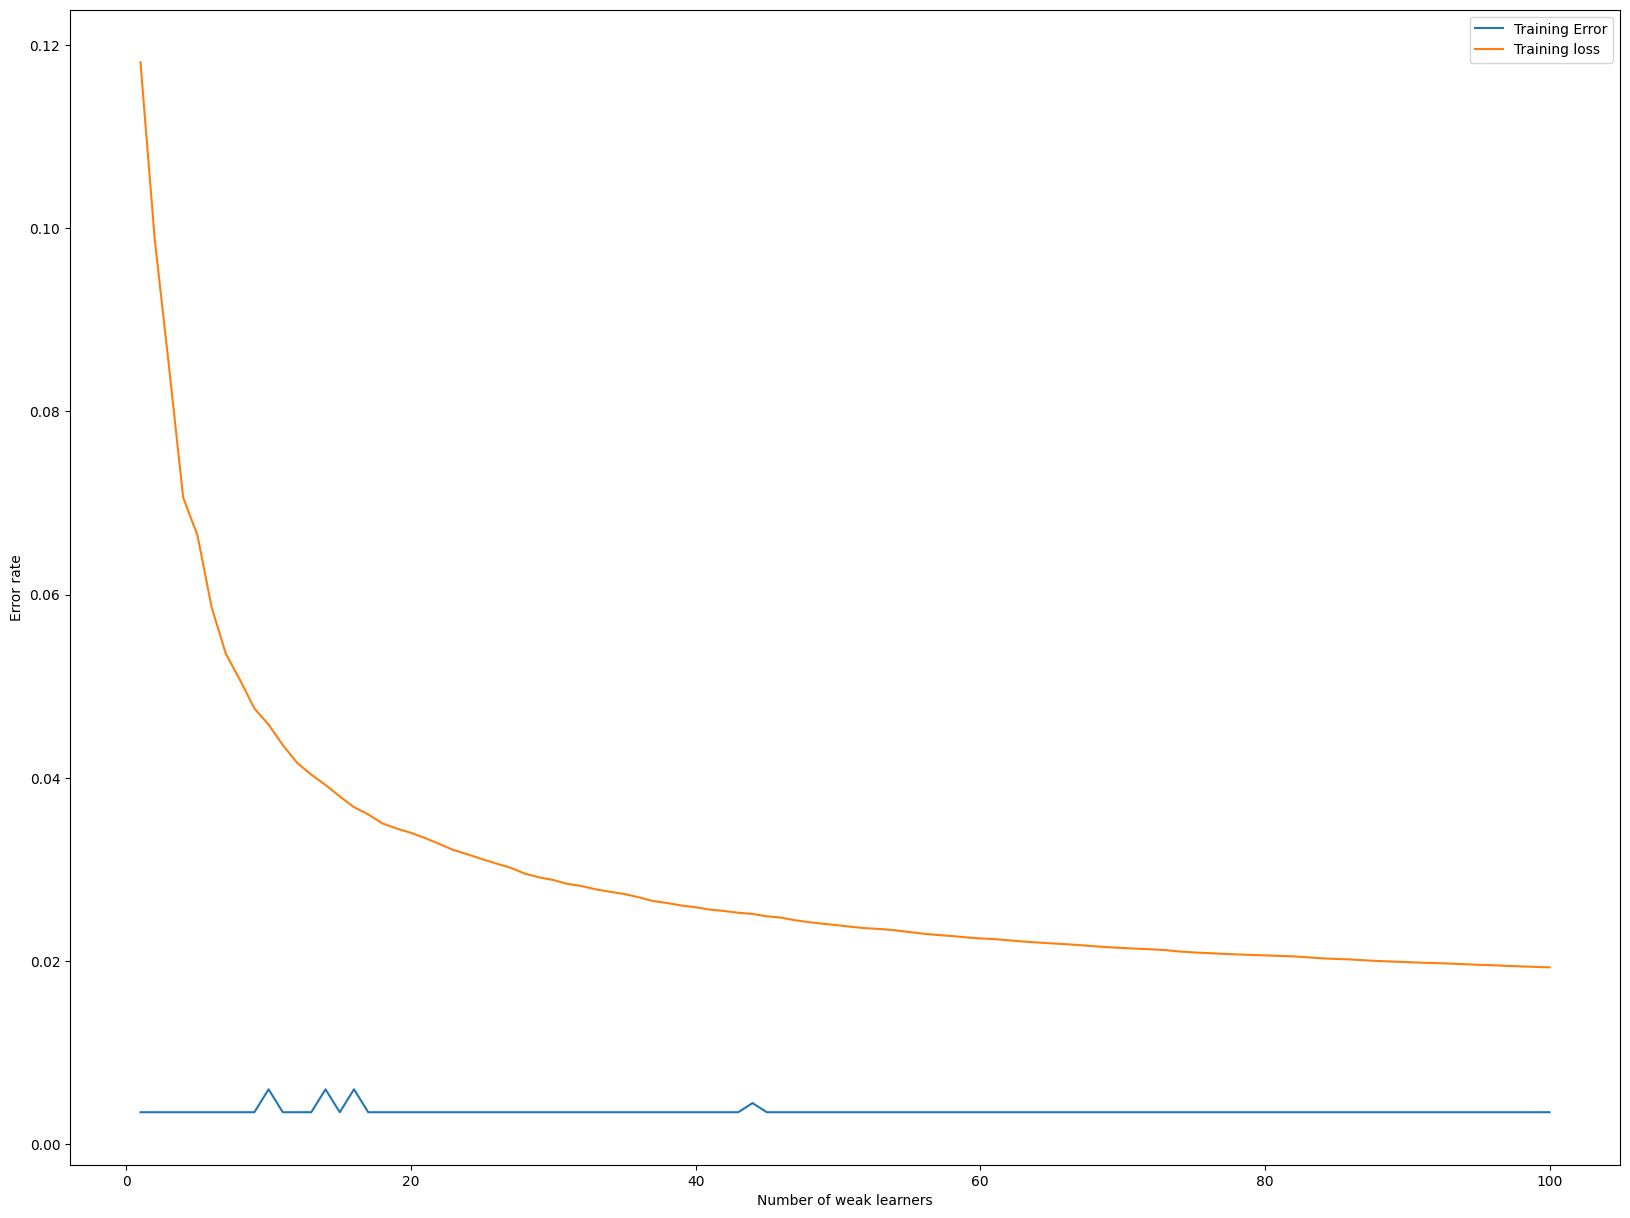

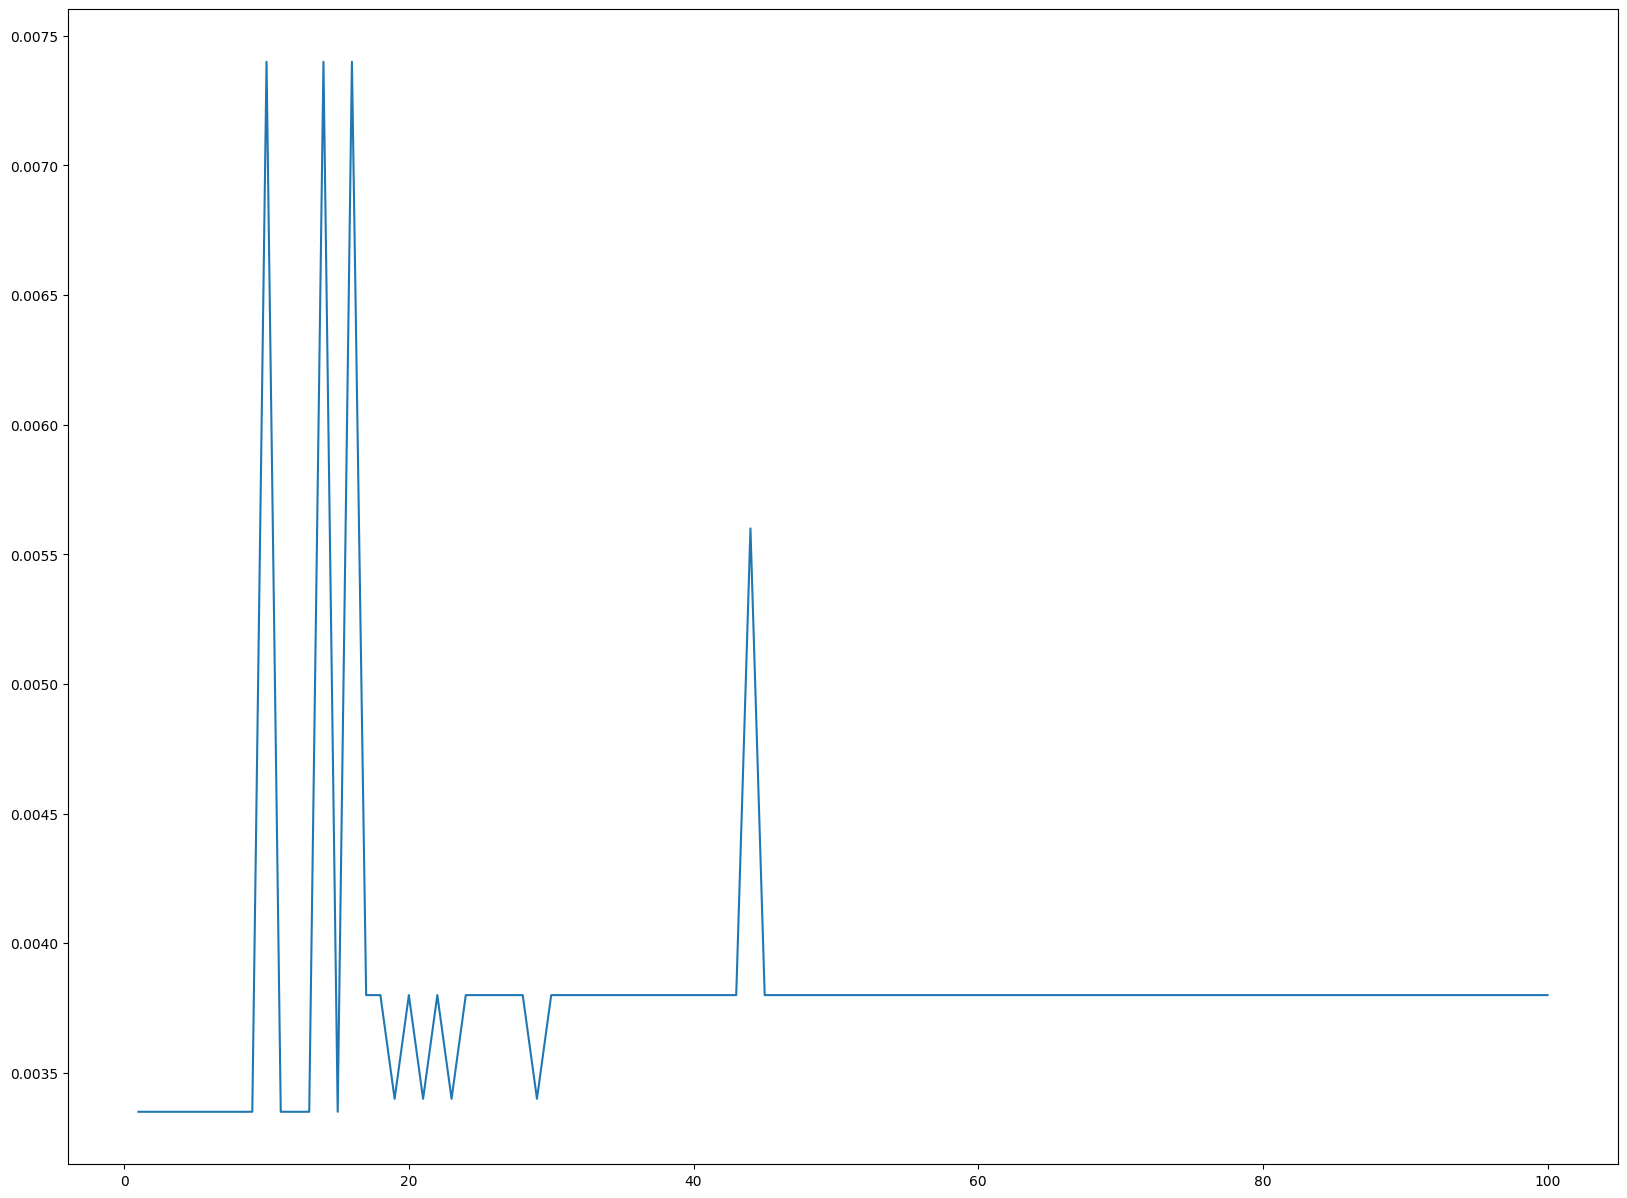

In [7]:
modelpca = Adaboost(x_train_pca, y_train, 100)
modelpca.fit()
modelpca.predict(x_test_pca, y_test)
modelpca.plot()
